ECEN 743: Reinforcement Learning \
Deep Q-Learning \
Shaunak Shailesh Kolhe \
133008312

In [1]:
!pip install gymnasium[box2d]
!pip3 install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 53.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement 

In [2]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import base64, io

# For visualization
from gymnasium.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [3]:
class ExperienceReplay:
	""" 
	Based on the Replay Buffer implementation of TD3 
	Reference: https://github.com/sfujim/TD3/blob/master/utils.py
	"""
	def __init__(self, state_dim, action_dim,max_size,batch_size,gpu_index=0):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.done = np.zeros((max_size, 1))		
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


	def add(self, state, action,reward,next_state, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.done[self.ptr] = done
		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self):
		ind = np.random.randint(0, self.size, size=self.batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).long().to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.done[ind]).to(self.device)
		)



In [4]:
class QNetwork(nn.Module):
	"""
	Q Network: designed to take state as input and give out Q values of actions as output
	"""

	def __init__(self, state_dim, action_dim):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
		"""
		super(QNetwork, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, action_dim)
		
	def forward(self, state):
		q = F.relu(self.l1(state))
		q = F.relu(self.l2(q))
		return self.l3(q)

In [5]:
class DQNAgent():

	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 tau=1e-3,
	 lr=5e-4,
	 update_freq=4,
	 max_size=int(1e5),
	 batch_size=64,
	 gpu_index=0
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			tau (float): used to update q-target
			lr (float): learning rate
			update_freq (int): update frequency of target network
			max_size (int): experience replay buffer size
			batch_size (int): training batch size
			gpu_index (int): GPU used for training
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.tau = tau
		self.lr = lr
		self.update_freq = update_freq
		self.max_size = max_size
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


		# Setting up the NNs
		self.Q = QNetwork(state_dim, action_dim).to(self.device)
		self.Q_target = QNetwork(state_dim, action_dim).to(self.device)
		self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

		# Experience Replay Buffer
		self.memory = ExperienceReplay(state_dim,1,max_size,self.batch_size,gpu_index)
		
		self.t_train = 0
	
	def step(self, experienced, target_network_enabled, state, action, reward, next_state, done):
		"""
		1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
		2. Learns when the experience replay buffer has enough samples
		3. Updates target netowork
		""" 
		self.t_train += 1
		self.memory.add(state, action, reward, next_state, done)	

		if experienced and target_network_enabled:
			if self.memory.size > self.batch_size:
				experiences = self.memory.sample()
				self.learn(experiences, self.discount) #To be implemented
				if(self.t_train % self.update_freq) == 0:
					self.target_update(self.Q, self.Q_target, self.tau)

		elif experienced and not target_network_enabled:
			if self.memory.size > self.batch_size:
				self.memory.add(state, action, reward, next_state, done)
				experiences = self.memory.sample()	   
				self.learn_with_exp_replay(experiences, self.discount)
		else:
			if self.memory.size > self.batch_size:
				self.learn_without_exp_replay(state, action, reward, next_state, done, self.discount)
				if(self.t_train % self.update_freq) == 0:
					self.target_update(self.Q, self.Q_target, self.tau)
		
#To be implemented 

	def select_action(self, state, epsilon = 0.):
		if np.random.random() > epsilon:
			state = torch.tensor(state, dtype=torch.float32, device=self.device) # converting our state to pytorch tensor
			#self.Q(state) # writing updated tensor to device
			self.Q.eval()
			with torch.no_grad():
				actions=self.Q.forward(state)
			self.Q.train()
			action = torch.argmax(actions).item()
		else:
				action=np.random.choice(self.action_dim) # Random choice of action from action space of enviornment
		
		return action
	
	def learn(self, experiences, discount):
		"""
		TODO: Complete this block to update the Q-Network using the target network
		1. Compute target using  self.Q_target ( tar get = r + discount * max_b [Q_target(s,b)] )
		2. Compute Q(s,a) using self.Q
		3. Compute MSE loss between step 1 and step 2
		4. Update your network
		Input: experiences consisting of states,actions,rewards,next_states and discount factor
		Return: None
		""" 		
		states, actions, rewards, next_states, dones = experiences
	
		q_eval = self.Q(states).gather(1, actions)
		q_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
		q_target = rewards + discount * q_next * (1-dones)
		loss = F.mse_loss(q_eval, q_target)
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()
		self.target_update(self.Q, self.Q_target, self.tau)


	def learn_with_exp_replay(self, experiences, discount):
		"""
		TODO: Complete this block to update the Q-Network using the target network
		1. Compute target using  self.Q_target ( tar get = r + discount * max_b [Q_target(s,b)] )
		2. Compute Q(s,a) using self.Q
		3. Compute MSE loss between step 1 and step 2
		4. Update your network
		Input: experiences consisting of states,actions,rewards,next_states and discount factor
		Return: None
		""" 		
		states, actions, rewards, next_states, dones = experiences
	
		q_eval = self.Q(states).gather(1, actions)
		q_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
		q_target = rewards + discount * q_next * (1-dones)
		loss = F.mse_loss(q_eval, q_target)
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()
		#self.target_update(self.Q, self.Q_target, self.tau)

	def learn_without_exp_replay(self, states, actions, rewards, next_states, dones, discount):
		"""
		TODO: Complete this block to update the Q-Network using the target network
		1. Compute target using  self.Q_target ( tar get = r + discount * max_b [Q_target(s,b)] )
		2. Compute Q(s,a) using self.Q
		3. Compute MSE loss between step 1 and step 2
		4. Update your network
		Input: experiences consisting of states,actions,rewards,next_states and discount factor
		Return: None
		""" 		
		states, actions, rewards, next_states, dones = [states], [actions], [rewards], [next_states], [dones]
		states = torch.tensor(states).float().to(self.device)
		actions = torch.tensor(actions).long().unsqueeze(1).to(self.device)  # Fix here
		rewards = torch.tensor(rewards).float().unsqueeze(1).to(self.device)  # Fix here
		next_states = torch.tensor(next_states).float().to(self.device)
		dones = torch.tensor(dones).unsqueeze(1).float().to(self.device)
		q_eval = self.Q(states).gather(1, actions)
		q_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
		q_target = rewards + discount * q_next * (1-dones)
		loss = F.mse_loss(q_eval, q_target)
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()
		self.target_update(self.Q, self.Q_target, self.tau)

	def target_update(self, Q, Q_target, tau):
		"""
		TODO: Update the target network parameters (param_target) using current Q parameters (param_Q)
		Perform the update using tau, this ensures that we do not change the target network drastically
		1. param_target = tau * param_Q + (1 - tau) * param_target
		Input: Q,Q_target,tau
		Return: None
		""" 
		###### TYPE YOUR CODE HERE ######
		for param_target, param_local in zip(Q_target.parameters(), Q.parameters()):
  			param_target.data.copy_(tau*param_local.data + (1.0-tau)*param_target.data)


		#param_target = tau * param_Q + (1 - tau) * param_target

**DQN with Experience Replay but no Target update**

REPLAY ENABLED, TARGET UPDATE DISABLED DQN
Episode Number 0 Average Episodic Reward (over 100 episodes): -142.22
Episode Number 100 Average Episodic Reward (over 100 episodes): -104.15
Episode Number 200 Average Episodic Reward (over 100 episodes): -119.90
Episode Number 300 Average Episodic Reward (over 100 episodes): -118.28
Episode Number 400 Average Episodic Reward (over 100 episodes): -113.80
Episode Number 500 Average Episodic Reward (over 100 episodes): -104.97
Episode Number 600 Average Episodic Reward (over 100 episodes): -114.10
Episode Number 700 Average Episodic Reward (over 100 episodes): -107.96
Episode Number 800 Average Episodic Reward (over 100 episodes): -107.89
Episode Number 900 Average Episodic Reward (over 100 episodes): -105.23
Episode Number 1000 Average Episodic Reward (over 100 episodes): -114.83
Episode Number 1100 Average Episodic Reward (over 100 episodes): -110.26
Episode Number 1200 Average Episodic Reward (over 100 episodes): -100.76
Episode Number 1300 

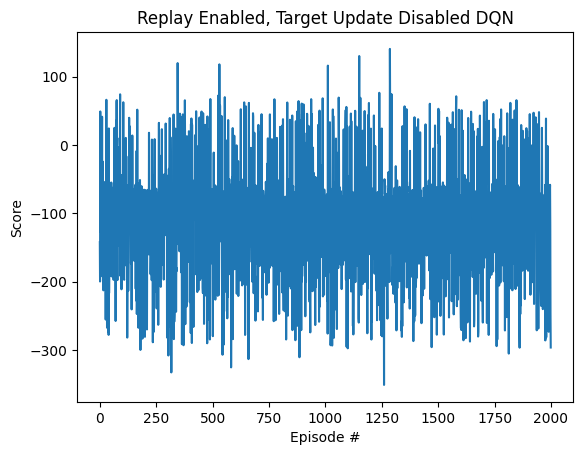

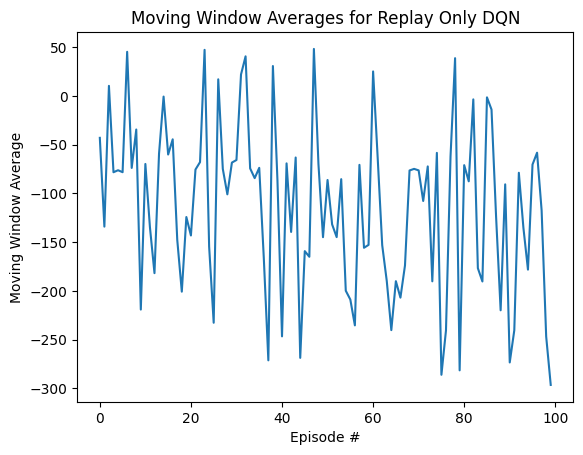

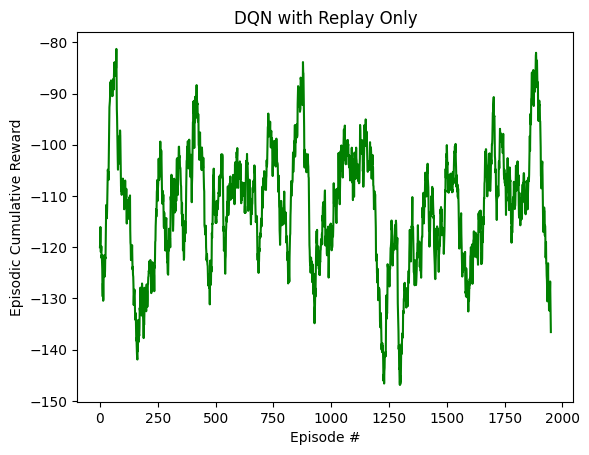

In [7]:
def experience_replay_notarget_trainer():
	seed = 0              
	n_episodes = 2000
	batch_size = 64
	discount = 0.99
	lr = 5e-4                       # learning rate
	tau = 0.001                     # soft update of target network
	max_size = int(1e5)
	update_freq = 4
	gpu_index = 0
	max_eps_len = 1000
	#exploration strategy

	epsilon = 1

	# making the environment	
	env = gym.make("LunarLander-v2")

	#setting seeds
	torch.manual_seed(seed)
	np.random.seed(seed)
	random.seed(seed)

	state_dim = env.observation_space.shape[0]
	action_dim = env.action_space.n

	kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":discount,
	 	"tau":tau,
	 	"lr":lr,
	 	"update_freq":update_freq,

	 	"max_size":max_size,
	 	"batch_size":batch_size,
	 	"gpu_index":gpu_index
	}	
	unupdated_learner = DQNAgent(**kwargs) #Creating the DQN learning agent

	moving_window = deque(maxlen=100)

	reward_store = []

	print("REPLAY ENABLED, TARGET UPDATE DISABLED DQN")
		
	 
	for e in range(n_episodes):
		state, _ = env.reset(seed=seed)
		curr_reward = 0
		for t in range(max_eps_len):
			action = unupdated_learner.select_action(state, epsilon) #To be implemented
			n_state,reward,terminated,truncated,_ = env.step(action)
			done = terminated or truncated 
			unupdated_learner.step(True, False, state, action, reward, n_state, done) #To be implemented
			state = n_state
			curr_reward += reward
			if done:
				break
		moving_window.append(curr_reward)
		reward_store.append(curr_reward)


		if e % 100 == 0:
			print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))

	###### TYPE YOUR CODE HERE ######
	plt.plot(np.arange(len(reward_store)), reward_store)
	plt.ylabel('Score')
	plt.xlabel('Episode #')
	plt.title('Replay Enabled, Target Update Disabled DQN')
	plt.show()

	plt.plot(np.arange(len(moving_window)), moving_window)
	plt.ylabel('Moving Window Average')
	plt.xlabel('Episode #')
	plt.title('Moving Window Averages for Replay Only DQN')
	plt.show()
		
	averages = []
	window_size=50	
	for i in range(len(reward_store) - window_size + 1):	
		window = reward_store[i:i+window_size]
		average = sum(window) / window_size
		averages.append(average)	
	plt.plot(averages, color='g')
	plt.ylabel('Episodic Cumulative Reward')
	plt.xlabel('Episode #')
	plt.title('DQN with Replay Only')
	plt.show()
		#################################
		
experience_replay_notarget_trainer()

**DQN with Target Update and no Experience Replay**

Target Update Disabled DQN
Episode Number 0 Average Episodic Reward (over 100 episodes): -121.30


<ipython-input-5-9c63b0a54478>:143: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.tensor(states).float().to(self.device)


Episode Number 100 Average Episodic Reward (over 100 episodes): -246.68
Episode Number 200 Average Episodic Reward (over 100 episodes): -170.87
Episode Number 300 Average Episodic Reward (over 100 episodes): -64.01
Episode Number 400 Average Episodic Reward (over 100 episodes): -152.57
Episode Number 500 Average Episodic Reward (over 100 episodes): -64.39
Episode Number 600 Average Episodic Reward (over 100 episodes): 41.06
Episode Number 700 Average Episodic Reward (over 100 episodes): 34.68
Episode Number 800 Average Episodic Reward (over 100 episodes): -52.96
Episode Number 900 Average Episodic Reward (over 100 episodes): -46.83
Episode Number 1000 Average Episodic Reward (over 100 episodes): -69.15
Episode Number 1100 Average Episodic Reward (over 100 episodes): -53.73
Episode Number 1200 Average Episodic Reward (over 100 episodes): -35.14
Episode Number 1300 Average Episodic Reward (over 100 episodes): -48.70
Episode Number 1400 Average Episodic Reward (over 100 episodes): -40.16


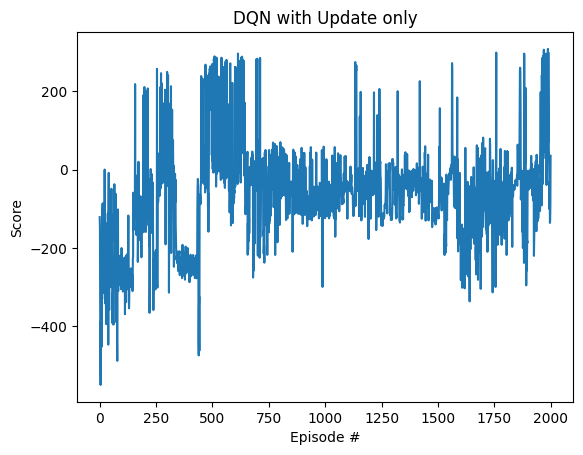

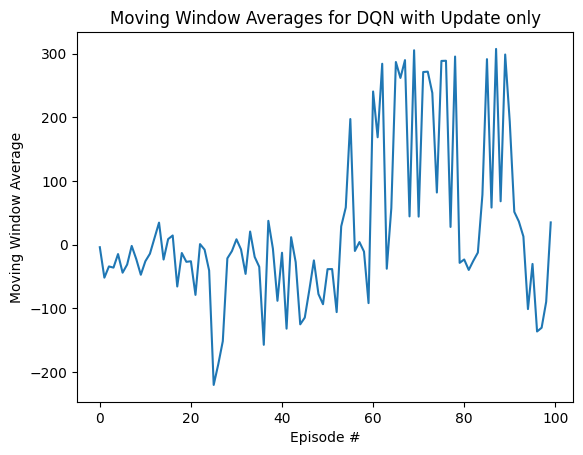

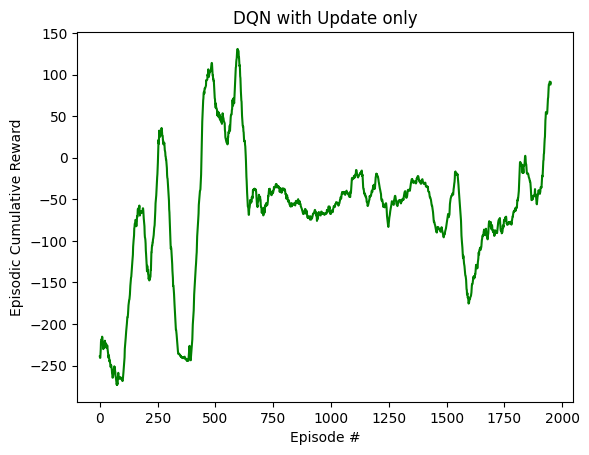

In [8]:
def without_experience_replay_trainer():
  seed = 0              
  n_episodes = 2000
  batch_size = 64
  discount = 0.99
  lr = 5e-4                       # learning rate
  tau = 0.001                     # soft update of target network
  max_size = int(1e5)
  update_freq = 4
  gpu_index = 0
  max_eps_len = 1000
  #exploration strategy 
  # making the environment	
  env = gym.make("LunarLander-v2")  
  #setting seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed) 
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n 
  kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":discount,
	 	"tau":tau,
	 	"lr":lr,
	 	"update_freq":update_freq,
	 	"max_size":max_size,
	 	"batch_size":batch_size,
	 	"gpu_index":gpu_index
	}	
  disabled_decaying_learner = DQNAgent(**kwargs) #Creating the DQN learning agent  
  moving_window = deque(maxlen=100)

  reward_store = []  

  print("Target Update Disabled DQN")

  epsilon_start = 1               # start value of epsilon
  epsilon_end = 0.01              # end value of epsilon
  epsilon_decay = 0.995           # decay value of epsilon	  

  epsilon_by_step = lambda step: float(epsilon_end+(epsilon_start - epsilon_end)*np.exp(-1. * step / epsilon_decay))

	 
  for e in range(n_episodes):
    state, _ = env.reset(seed=seed)
    curr_reward = 0
    for t in range(max_eps_len):
      action = disabled_decaying_learner.select_action(state, epsilon_by_step(t)) #To be implemented
      n_state,reward,terminated,truncated,_ = env.step(action)
      done = terminated or truncated 
      disabled_decaying_learner.step(False, True, state, action, reward, n_state, done) #To be implemented
      state = n_state
      curr_reward += reward
      if done:
        break
    reward_store.append(curr_reward)
    moving_window.append(curr_reward)

    if e % 100 == 0:
      print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))

	###### TYPE YOUR CODE HERE ######
  plt.plot(np.arange(len(reward_store)), reward_store)
  plt.ylabel('Score')
  plt.xlabel('Episode #')
  plt.title('DQN with Update only')
  plt.show()

  plt.plot(np.arange(len(moving_window)), moving_window)
  plt.ylabel('Moving Window Average')
  plt.xlabel('Episode #')
  plt.title('Moving Window Averages for DQN with Update only')
  plt.show()

  averages = []
  window_size=50

  for i in range(len(reward_store) - window_size + 1):	
    window = reward_store[i:i+window_size]
    average = sum(window) / window_size
    averages.append(average)

  plt.plot(averages, color='g')
  plt.ylabel('Episodic Cumulative Reward')
  plt.xlabel('Episode #')
  plt.title('DQN with Update only')
  plt.show()
		#################################

without_experience_replay_trainer()

**Inferences**

By removing the experience and target update parts, we can identify the contributions of each of those components to the learning algorithm. For more complex models, we can use this method to identify the effects of each of these on the performance of each the components of the model. However, runtime for these models is horribly slow.